# IMPORT LIBRARY

In [ ]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# IMPORT DATA

In [ ]:
d1 = pd.read_csv('travel.csv')
d1 = d1.iloc[:, 1:]

In [ ]:
d1.shape

(100000, 24)

In [ ]:
d1.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-11-03 16:02:28,24,2,77,871,36643,456.1151,792280,0,1,...,0,1,8286,1,0,1,0,63,1258,68
1,2013-03-13 19:25:01,11,3,205,135,38749,232.4737,961995,0,0,...,0,1,1842,3,0,1,2,198,786,37
2,2014-10-13 13:20:25,2,3,66,314,48562,4468.2720,495669,0,1,...,0,1,8746,1,0,1,6,105,29,22
3,2013-11-05 10:40:34,11,3,205,411,52752,171.6021,106611,0,0,...,0,1,6210,3,1,1,2,198,1234,42
4,2014-06-10 13:34:56,2,3,66,174,50644,NaN,596177,0,0,...,1,1,12812,5,0,1,2,50,368,83


# IDENTIFY IMBALANCED DATA

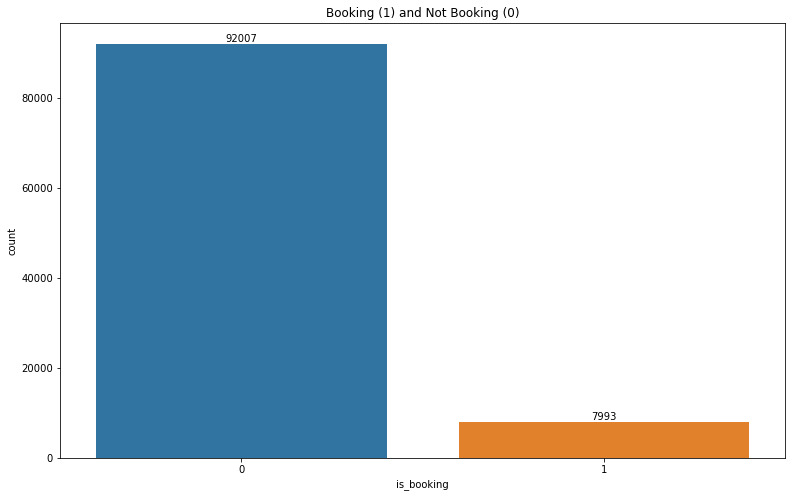

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.countplot(x='is_booking', data=d1, order=[0,1], ax=ax)
counts = d1['is_booking'].value_counts()

for i, count in enumerate(counts):
    ax.text(i, count, str(count), ha='center', va='bottom')
ax.set_title('Booking (1) and Not Booking (0)')

plt.show()

# DATA QUALITY CHECK

In [ ]:
d1.isnull().sum()

date_time                        0
site_name                        0
posa_continent                   0
user_location_country            0
user_location_region             0
user_location_city               0
orig_destination_distance    36085
user_id                          0
is_mobile                        0
is_package                       0
channel                          0
srch_ci                        122
srch_co                        122
srch_adults_cnt                  0
srch_children_cnt                0
srch_rm_cnt                      0
srch_destination_id              0
srch_destination_type_id         0
is_booking                       0
cnt                              0
hotel_continent                  0
hotel_country                    0
hotel_market                     0
hotel_cluster                    0
dtype: int64

In [ ]:
d1.dtypes

date_time                     object
site_name                      int64
posa_continent                 int64
user_location_country          int64
user_location_region           int64
user_location_city             int64
orig_destination_distance    float64
user_id                        int64
is_mobile                      int64
is_package                     int64
channel                        int64
srch_ci                       object
srch_co                       object
srch_adults_cnt                int64
srch_children_cnt              int64
srch_rm_cnt                    int64
srch_destination_id            int64
srch_destination_type_id       int64
is_booking                     int64
cnt                            int64
hotel_continent                int64
hotel_country                  int64
hotel_market                   int64
hotel_cluster                  int64
dtype: object

# FEATURE ENGINEERING

In [ ]:
d1["date_time"] = pd.to_datetime(d1["date_time"])
d1["year"] = d1["date_time"].dt.year
d1["month"] = d1["date_time"].dt.month

d1['srch_ci']=pd.to_datetime(d1['srch_ci'],infer_datetime_format = True,errors='coerce')
d1['srch_co']=pd.to_datetime(d1['srch_co'],infer_datetime_format = True,errors='coerce')

d1['plan_time'] = ((d1['srch_ci']-d1['date_time'])/np.timedelta64(1,'D')).astype(float)
d1['hotel_nights']=((d1['srch_co']-d1['srch_ci'])/np.timedelta64(1,'D')).astype(float)

mean_distance = d1['orig_destination_distance'].mean()
d1['orig_destination_distance'].fillna(mean_distance, inplace=True)

cols_to_drop = ['date_time', 'srch_ci', 'srch_co', 'user_id']
d1.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
d1.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,...,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,plan_time,hotel_nights
0,24,2,77,871,36643,456.115100,0,1,1,2,...,0,1,0,63,1258,68,2014,11,41.331620,4.0
1,11,3,205,135,38749,232.473700,0,0,9,2,...,0,1,2,198,786,37,2013,3,-0.809039,1.0
2,2,3,66,314,48562,4468.272000,0,1,9,2,...,0,1,6,105,29,22,2014,10,171.444155,7.0
3,11,3,205,411,52752,171.602100,0,0,0,2,...,1,1,2,198,1234,42,2013,11,1.555162,1.0
4,2,3,66,174,50644,1960.661721,0,0,9,2,...,0,1,2,50,368,83,2014,6,53.434074,5.0


# DEALING WITH IMBALANCED DATA

In [ ]:
booking_indices = d1[d1.is_booking == 1].index
random_indices = np.random.choice(booking_indices, len(d1.loc[d1.is_booking == 1]), replace=False)
booking_sample = d1.loc[random_indices]

not_booking = d1[d1.is_booking == 0].index
random_indices = np.random.choice(not_booking, sum(d1['is_booking']), replace=False)
not_booking_sample = d1.loc[random_indices]

d1_new = pd.concat([not_booking_sample, booking_sample], axis=0)

print("Percentage of not booking clicks: ", len(d1_new[d1_new.is_booking == 0])/len(d1_new))
print("Percentage of booking clicks: ", len(d1_new[d1_new.is_booking == 1])/len(d1_new))
print("Total number of records in resampled data: ", len(d1_new))

Percentage of not booking clicks:  0.5
Percentage of booking clicks:  0.5
Total number of records in resampled data:  15986


In [ ]:
#Shuffle the resampled dataframe
d1_new = d1_new.sample(frac=1).reset_index(drop=True)
d1_new.shape

(15986, 24)

In [ ]:
#Assign features and label from the new dataframe
X = d1_new.loc[:, d1_new.columns != 'is_booking']
y = d1_new.loc[:, d1_new.columns == 'is_booking']

In [ ]:
X.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,...,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,plan_time,hotel_nights
0,2,3,66,462,49272,876.139000,0,1,9,2,...,1,1,2,50,628,88,2013,11,80.629803,3.0
1,2,3,66,435,39058,4395.487200,1,1,9,2,...,1,1,2,50,213,84,2014,5,306.689340,8.0
2,24,2,3,50,5703,1960.661721,0,1,9,2,...,1,1,3,5,1701,57,2014,3,62.422662,3.0
3,37,1,69,567,47755,1960.661721,0,1,9,4,...,1,2,6,77,1422,46,2014,3,94.281400,7.0
4,2,3,66,174,36330,2585.775300,0,0,9,2,...,3,1,2,50,212,33,2013,4,50.236204,3.0


# PCA

In [ ]:
scaler = StandardScaler()
X=scaler.fit_transform(X)
X

array([[-0.63605552,  0.41803695, -0.34446313, ...,  1.20597576,
         0.56767636,  0.01623616],
       [-0.63605552,  0.41803695, -0.34446313, ..., -0.627271  ,
         4.27444768,  1.68540519],
       [ 1.20257906, -0.93474416, -1.41029356, ..., -1.23835325,
         0.26912798,  0.01623616],
       ...,
       [ 2.28904495, -2.28752527, -0.2937093 , ..., -0.01618875,
        -0.20165264, -0.31759765],
       [ 0.61755897, -2.28752527,  2.36240781, ..., -0.01618875,
        -0.69721391,  0.01623616],
       [-0.63605552,  0.41803695, -0.34446313, ...,  0.5948935 ,
        -0.69921575, -0.65143145]])

In [ ]:
X = np.nan_to_num(X)
X[X == np.inf] = np.nan

X = X[~np.isnan(X).any(axis=1)]

pca = PCA(n_components=23)
pca.fit(X)

PCA(n_components=23)

In [ ]:
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var

array([  9.7,  17.3,  24.3,  30.2,  35.7,  41. ,  46. ,  50.6,  55.1,
        59.5,  63.8,  67.9,  72. ,  75.9,  79.7,  83.4,  86.7,  89.7,
        92.4,  94.8,  97.1,  99. , 100.1])

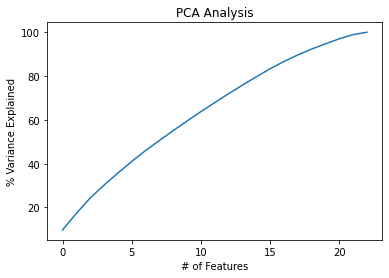

In [ ]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')

plt.plot(var)

# TRAIN, PREDICT AND PERFORMANCE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.shape

(11190, 23)

# RANDOMFORESTCLASSIFIER

In [ ]:
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy', accuracy_score(y_test, y_pred))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19056\1453071118.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


[[1221 1207]
 [ 596 1772]]
Accuracy 0.6240617180984154


# LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
pca = PCA(n_components=23)
logReg = LogisticRegression()

pipe = Pipeline([('pca', pca), ('logistic', logReg)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy', accuracy_score(y_test, y_pred))

[[1272 1156]
 [ 389 1979]]
Accuracy 0.6778565471226021


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# DATA VISUALIZATION

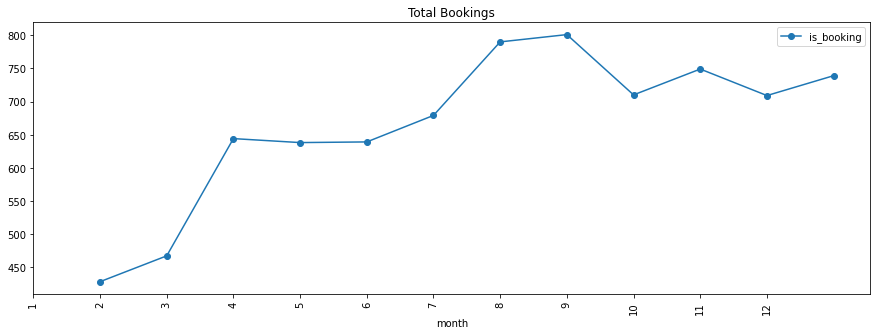

In [ ]:
# Plot number of bookings over Month
date_bookings  = d1.groupby('month')["is_booking"].sum()
ax1 = date_bookings.plot(legend=True,marker='o',title="Total Bookings", figsize=(15,5))
ax1.set_xticks(range(len(date_bookings)))
xlabels = ax1.set_xticklabels(date_bookings.index.tolist(), rotation=90)

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


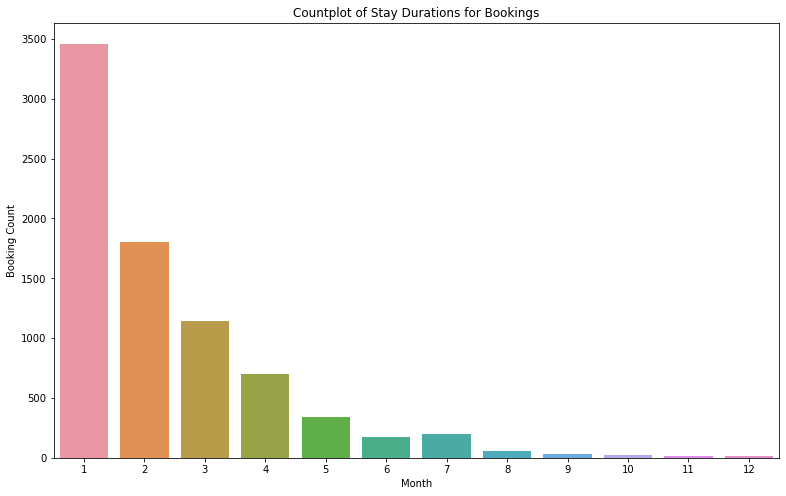

In [ ]:
# Countplot of Stay Durations for Bookings
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
booking_data = d1[d1["is_booking"] == 1]
sns.countplot('hotel_nights', data=booking_data, order=list(range(1, 13)), ax=ax)
ax.set(xlabel='Month', ylabel='Booking Count', title='Countplot of Stay Durations for Bookings')
plt.show()

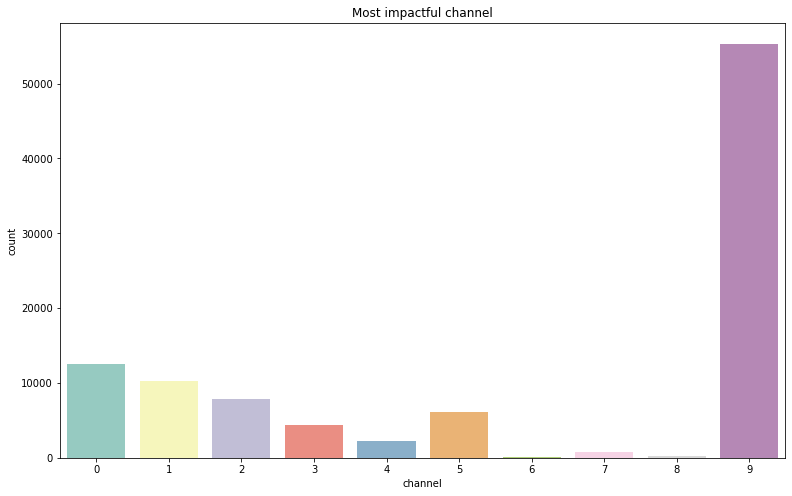

In [ ]:
# Most impactful channel Chart
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot(x='channel', order=list(range(0, 10)), data=d1, palette="Set3", ax=ax)
ax.set_title('Most impactful channel')

plt.show()

Text(0.5, 1.0, 'Correlation between different fearures')

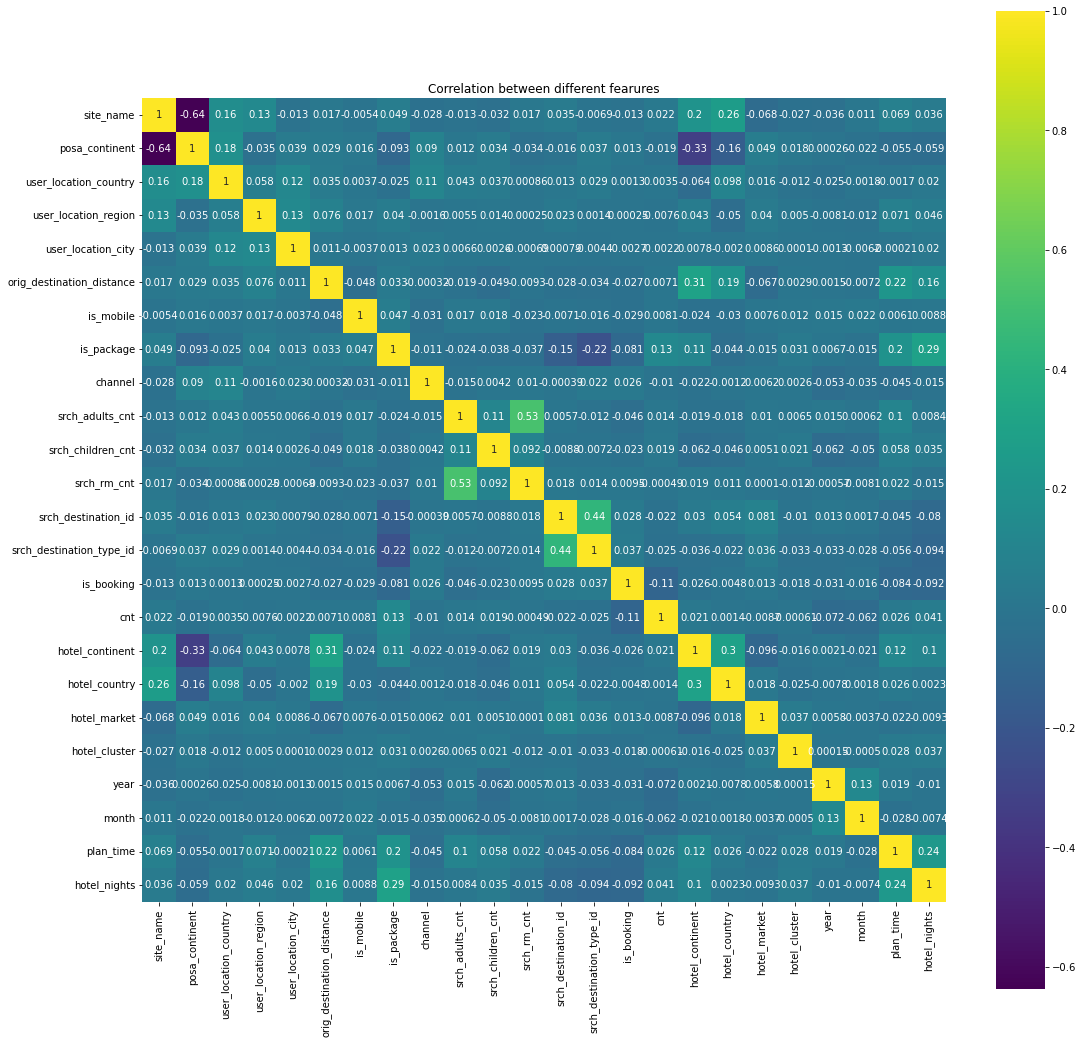

In [ ]:
correlation = d1.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Correlation between different fearures')